# Segmentación mediante clustering

# Objetivo: 


Usando el archivo 'Country-data.csv' que contiene datos de  países,
Completar los siguientes puntos que representan los pasos para segmentarlos (clusterización) en 3 categorías :

- desarrollado
- vías de desarrollo
- subdesarrollo

usando las 2 primeras característias mas relevantes basado el método de **mutual information** usando como etiqueta la columna 'gdpp'

Desarrolle el clusterizador usando el algoritmo de  K-means para que se obtengan 3 clusters que podrían significar los 3 tipos de países

Se presente una tabla que sumariza el contexto de la información



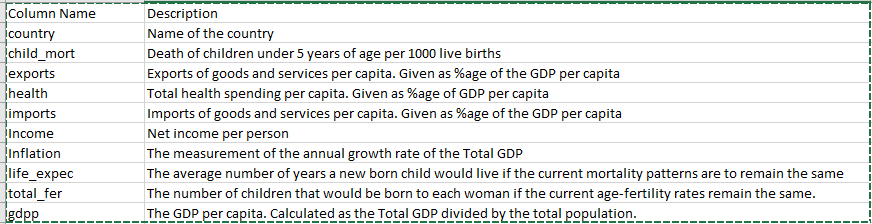

 # Instrucciones:

Considere los siguientes pasos

1. Importe las bibliotecas requeridas
1. Debe leer el archivo 'Country-data.csv' para obtener un pandas dataframe
1. Limpieza: Revise si hay filas que contengas valores faltantes (nan, nulos, etc). Elimine las filas que contengan valores faltantes
1. Debe usar el el algoritmo 'mutual information' para seleccionar únicamente las 2 columnas más importantes usando como referencia la columna: 'gdpp'
1. Defina una lista con las columnas features obtenida en en paso anterior
1. Filtre el dataframe usando la lista de columnas del paso anterior
1. Escale los datos
1. Aplique el método de Kmean
1. Crear la columna 'Cluster' hacia el dataframe que contiene la etiqueta.
1. Muestre el resultado en forma de visualizaciones que permitan explicar si la segmentación obtenida tiene sentido práctico en la realidad internacional. Sea amplio en su respuesta. Haga contraste entre países. Prueba con nuevos datos.



**1. Importe las bibliotecas requeridas**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [2]:
# Para aplicar mutual information
from sklearn.feature_selection import mutual_info_regression

# Para crear la red neuronal
import tensorflow as tf
from tensorflow import keras

In [3]:
# Para hacer un poco de ajuste y aspecto a las figuras
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

<ipython-input-3-1395973086d2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [4]:

import plotly.express as px
!pip install kneed
import plotly.express as px
import plotly.graph_objects as go

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

# Para el escalado
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Para partir el dataset en training y testing
from sklearn.model_selection import train_test_split

# Para medir el rendimiento
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**2. Extraer: Leer el archivo Country-data para obtener un pandas dataframe**

Se realiza la carga de los datos que vienen del archivo. Y seguidamente se visualiza el dataframe para revisar su contenido. Asi como la coleccion de todas las columnas.

In [5]:
df = pd.read_csv("Country-data.csv")
df.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

In [6]:
df.columns.values

array(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'], dtype=object)

In [7]:
df.shape

(167, 10)

In [8]:
df.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

**3. Limpieza**

**Revision e Inspeccion**. En lugar de imprimir el marco de datos con True/False como entrada (df.isna()), podemos extraer la información relevante agregando un .sum() junto con el comando anterior. Con esto podemos encontrar el número total de valores faltantes para cada columna.
Al agregar otro .sum() se devuelve el número total de valores nulos en el conjunto de datos.

In [9]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [10]:
df.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [11]:
df.isna().sum().sum()

0

No existen datos faltantes en este set de informacion. 

Limpieza de datos. 
Si probamos con la eliminación de filas que contienen valores NA en cualquiera de las columnas, da el mismo shape, pues no hay nada que eliminar.

In [12]:
clean_df = df.dropna(how='any')

In [13]:
clean_df

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2       5.82    553  
1         4.49        76.3       1.65   4090  
2        16.10        76.5       2.89   4460  
3        22.40        60.1       6.16   3530  
4         1.44        76.8       2.13  12200  
..         ...         ...        ...    ...  
162       2.62        63.0       3.50   2970  
163      45.90        75.4       2.47  13500  
164      12.10        73.1       1.95   1310  
165      23.60        67.5       4.67   1310  
166      14.00        52.0       5.40   1460  

[167 rows x 10 columns]

In [14]:
clean_df.shape

(167, 10)

Se nota que como no existian NAs entonces se mantiene el mismo shape que tenia antes. 

**4. Algoritmo de mutual information: para seleccionar las 2 columnas mas importantes usando como referencia la columna de gdpp**

Separando características y las etiquetas

In [15]:
df.describe()

child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000  
50%      5.390000   73.100000    2.410000    4660.000000  
75%     10.750000   76.800000    3.880000   14050.000000  
max    104.000000   82.800000    7.490000  105000.000000

In [16]:
X = df.copy()
y = X.pop("gdpp")

In [17]:
X.shape

(167, 9)

In [18]:
y.shape

(167,)

In [19]:
X

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer  
0         9.44        56.2       5.82  
1         4.49        76.3       1.65  
2        16.10        76.5       2.89  
3        22.40        60.1       6.16  
4         1.44        76.8       2.13  
..         ...         ...        ...  
162       2.62        63.0       3.50  
163      45.90        75.4       2.47  
164      12.10        73.1       1.95  
165      23.60        67.5       4.67  
166      14.00        52.0       5.40  

[167 rows x 9 columns]

In [20]:
y

0        553
1       4090
2       4460
3       3530
4      12200
       ...  
162     2970
163    13500
164     1310
165     1310
166     1460
Name: gdpp, Length: 167, dtype: int64

In [21]:
# Codifica etiquetas a las columnas que no son numéricas. Por ejemplo las que tienen texto
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Es un marcado o bandera para señalar cual columna tiene información discreta.
# Es importante paso. Asegurese de tenerla
discrete_features = X.dtypes == int

In [22]:
# obtiene la mutual informacion
mi_scores = mutual_info_regression(X, y, discrete_features="auto")
# crea una estructura (la pandas series). Es una buena opción para manipular los datos
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
# ordena los datos de mayor a menor
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores  # Muestra los resultados

income        1.637586
life_expec    0.699094
child_mort    0.654035
total_fer     0.438135
inflation     0.102298
exports       0.075312
health        0.057294
imports       0.036465
country       0.004137
Name: MI Scores, dtype: float64

Los variables que mas influyen son income y life expectancy

**5. Define los Features**

In [23]:
features = ["income", "life_expec"]


**6. Filtre el dataframe usando la lista de columnas del paso anterior**

In [24]:
X = df[features].copy()
X.head()

income  life_expec
0    1610        56.2
1    9930        76.3
2   12900        76.5
3    5900        60.1
4   19100        76.8

**7. Escale los datos**

In [25]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

**8. Aplique el metodo de K Mean**

Ya se tiene un escalado de datos de los puntos anteriores. Se procede a aplicar el metodo Kmeans

In [26]:
kmeans = KMeans(n_clusters=3, n_init='auto')

**9. Crear la columna 'cluster' hacia el dataframa que contiene la etiqueta**

In [27]:
df["Cluster"] = kmeans.fit_predict(X)

In [28]:
df["Cluster"] =df["Cluster"].astype("category")
df.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp Cluster  
0       9.44        56.2       5.82    553       1  
1       4.49        76.3       1.65   4090       0  
2      16.10        76.5       2.89   4460       0  
3      22.40        60.1       6.16   3530       1  
4       1.44        76.8       2.13  12200       0

Se procede a explorar los datos con la columna Cluster para confirmar su razonabilidad.

In [29]:
df.iloc[:,[0,10]]

country Cluster
0            Afghanistan       1
1                Albania       0
2                Algeria       0
3                 Angola       1
4    Antigua and Barbuda       0
..                   ...     ...
162              Vanuatu       1
163            Venezuela       0
164              Vietnam       0
165                Yemen       1
166               Zambia       1

[167 rows x 2 columns]

In [30]:
df.sort_values('Cluster',ascending=False)

country  child_mort  exports  health  imports  income  inflation  \
114       Norway         3.2     39.7    9.48     28.5   62300      5.950   
23        Brunei        10.5     67.4    2.84     28.0   80600     16.700   
91    Luxembourg         2.8    175.0    7.77    142.0   91700      3.620   
82        Kuwait        10.8     66.7    2.63     30.4   75200     11.200   
123        Qatar         9.0     62.3    1.81     23.8  125000      6.980   
..           ...         ...      ...     ...      ...     ...        ...   
39    Costa Rica        10.2     33.2   10.90     35.0   13000      6.570   
86       Lebanon        10.3     35.8    7.03     60.2   16300      0.238   
85        Latvia         7.8     53.7    6.68     55.1   18300     -0.812   
41       Croatia         5.5     37.6    7.76     38.1   20100      0.821   
110  Netherlands         4.5     72.0   11.90     63.6   45500      0.848   

     life_expec  total_fer    gdpp Cluster  
114        81.0       1.95   87800       2  
23         77.1       1.84   35300       2  
91         81.3       1.63  105000       2  
82         78.2       2.21   38500       2  
123        79.5       2.07   70300       2  
..          ...        ...     ...     ...  
39         80.4       1.92    8200       0  
86         79.8       1.61    8860       0  
85         73.1       1.36   11300       0  
41         76.3       1.55   13500       0  
110        80.7       1.79   50300       0  

[167 rows x 11 columns]

In [31]:
df.Cluster.nunique()
# consultando la cantidad de valores únicos de una columna. Se confirma que hay 3.
#  tabla.columna      .nunique()

3

In [32]:
#                  tabla.columna     .unique()
# para confirmar los diferentes valores de la columna Cluster
df_lista = df.Cluster.unique().tolist()
df_lista

[1, 0, 2]

In [33]:
# quiero saber cuantos paises hay en cada una
df.groupby('Cluster').size()

Cluster
0    96
1    62
2     9
dtype: int64

In [34]:
df.groupby('Cluster').mean()
# se puede observar que el cluster 1 es de menor gdpp, el 0 es medio y el 2 es alto. Para efectos del ejercicio:
# 2 es desarrollado, 0 es vías de desarrollo y 1 es subdesarrollo 

<ipython-input-34-8bebfd1475b5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Cluster').mean()


child_mort    exports    health    imports        income  inflation  \
Cluster                                                                        
0         14.540625  42.936458  7.178333  46.289583  20209.583333   5.723333   
1         79.608065  31.904823  6.250806  45.604289   4091.016129  11.156210   
2          6.611111  85.022222  6.838889  62.155556  74377.777778   6.493444   

         life_expec  total_fer          gdpp  
Cluster                                       
0         75.905208   2.095000  15681.125000  
1         60.946774   4.435806   1905.258065  
2         79.688889   1.796667  60166.666667

**10. Muestre el resultado en forma de visualizaciones que permita explicar si la segmentacion obtenida tiene sentido practico en la realidad internacional. Sea amplio. Haga contrastes entre paises y pruebe con nuevos datos.**

Text(0.5, 1.0, 'Mutual Information Scores')

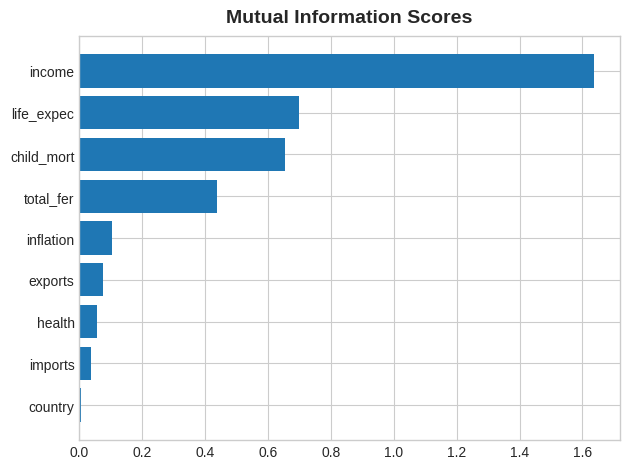

In [35]:
scores = mi_scores.sort_values(ascending=True)[-20:]
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
# Lo anterior confirma las diferentes features que impactan el GDPP

La visualización de datos es un gran instrumento para evaluar las características.

Como era de esperar, la característica de income/ingreso tiene alta puntuación  exhibe una fuerte relación con  el GDPP (GDP per capita) que es el objeto del analisis. Seguido de la expectativa de vida.

Graficando se puede observar la relación del GDPP aumenta conforme aumenta el income, tienen una relacion directa. 

(<seaborn.axisgrid.FacetGrid at 0x7f37e57e9480>,
 Text(0.5, 1.0, 'GDPP per income'))

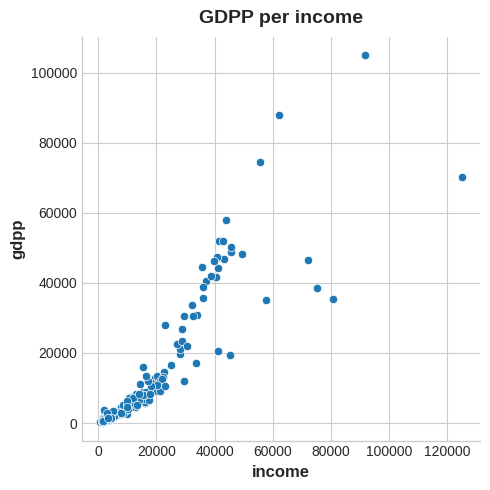

In [36]:
sns.relplot(x="income", y="gdpp", data=df),plt.title("GDPP per income")
# A mayor ingreso mayor GDPP

Por otro lado se puede observar que el GDPP aumenta sustancialmente cuando la expectativa de vida supera los 60.

(<seaborn.axisgrid.FacetGrid at 0x7f37e56cb700>,
 Text(0.5, 1.0, 'GDPP per Life_expec'))

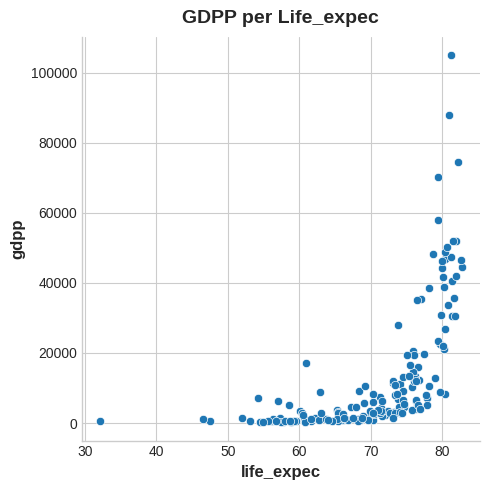

In [37]:
sns.relplot(x="life_expec", y="gdpp", data=df),plt.title("GDPP per Life_expec")
# a mas edad mayor GDPP

Considerando que con base en la clusterizacion, se definieron 3 escalas:
 2 es desarrollado
 0 es vías de desarrollo
 1 es subdesarrollo 

 Se evidencia que los paises Desarrollados (2) son los que tienen mayor ingreso y expectativa de vida, mientras que los paises subdesarrollados (1) cuentan con menor ingreso y expectativa de vida con lo cual su gdpp es menor.

(<seaborn.axisgrid.FacetGrid at 0x7f37e5583610>,
 Text(0.5, 1.0, 'Cluster segun Income y Life_expect: 2-desarrollado/ 0-vías de desarrollo/ 1-subdesarrollo'))

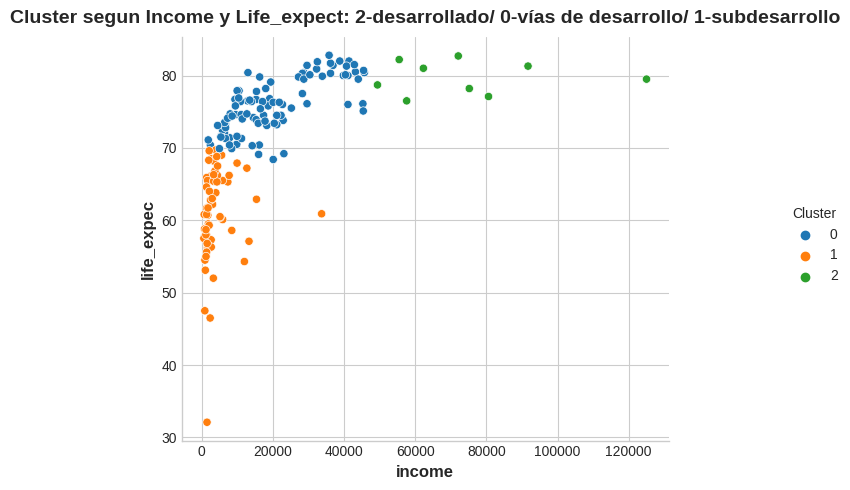

In [38]:
sns.relplot(
    x="income", y="life_expec", hue="Cluster", data=df, height=5,),plt.title("Cluster segun Income y Life_expect: 2-desarrollado/ 0-vías de desarrollo/ 1-subdesarrollo")

Los paises 1 que son los subdessarollados tienen mayor oportunidad de crecimiento en el gdpp. Mientras que los desarrollados no. 

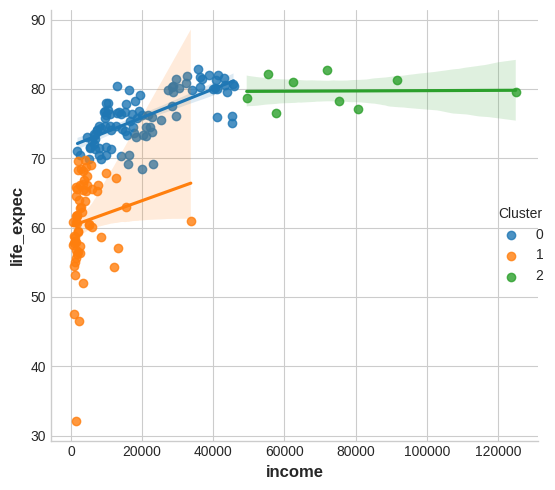

In [39]:
sns.lmplot(x="income", y="life_expec", hue="Cluster", data=df);

Los paises desarrollados como se nota en las siguientes figuras poseen el mayor income y mayor expectativa de vida.
Mientras que los paises subdesarrollados tienen menor expectiva y el menor rango de ingresos 

(<Axes: title={'center': 'Income by cluster'}, xlabel='Cluster', ylabel='income'>,
 Text(0.5, 1.0, 'Income by cluster'))

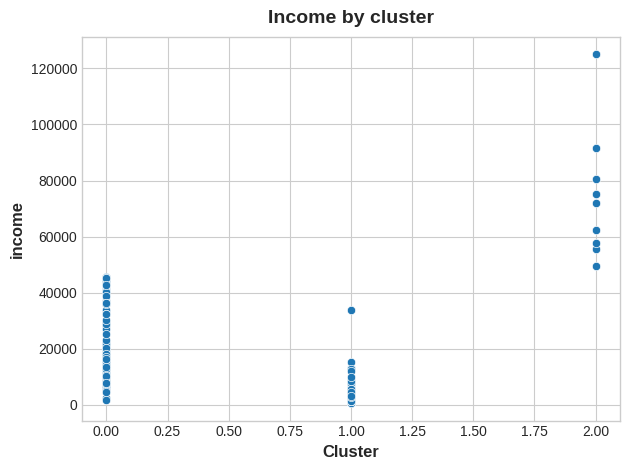

In [40]:
sns.scatterplot(x='Cluster', y='income', data=df),plt.title("Income by cluster")

(<Axes: title={'center': 'Life-expec by cluster'}, xlabel='Cluster', ylabel='life_expec'>,
 Text(0.5, 1.0, 'Life-expec by cluster'))

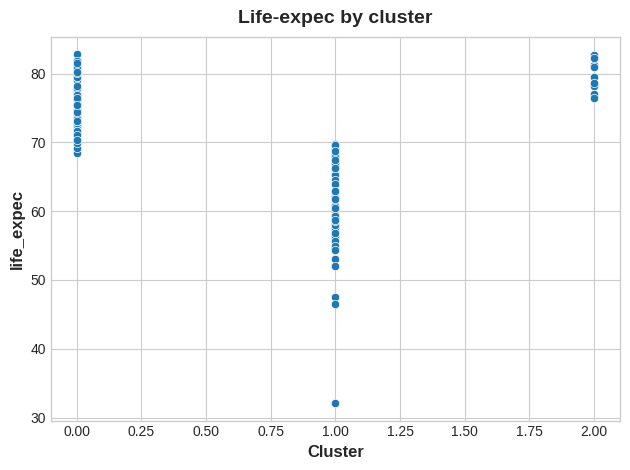

In [41]:
sns.scatterplot(x='Cluster', y='life_expec', data=df), plt.title("Life-expec by cluster")

**Se procede a etiquetar y hacer comparacion por paises con base en las cagtegorias antes mencionadas.**

In [42]:
#Definir las 3 categorias indicadas por los clusters.
df["income_categorias"], income_categorias_bines = pd.cut(df["income"], 3, labels=["subdesarrollado", "vías_desarrollo", "desarrollado"], retbins=True)
df["life_expec_categorias"], life_expec_categorias_bines = pd.cut(df["life_expec"], 3, labels=["subdesarrollado", "vías_desarrollo", "desarrollado"], retbins=True)

Se revisan los rangos creados para cada uno.

In [43]:
# Ver como se contruyeron los intevalos de income_categorias_bines
print('income_categorias_bines')
print(income_categorias_bines)


income_categorias_bines
[   484.609       42072.66666667  83536.33333333 125000.        ]


In [44]:
# Ver como se contruyeron los intevalos de life_expec_categorias_bines
print('life_expec_categorias_bines')
print(life_expec_categorias_bines)

life_expec_categorias_bines
[32.0493 49.     65.9    82.8   ]


Se ilustra la division de los paises segun las categorias y rangos antes definidos.

In [45]:
#agrupar segun las nuevas categorias
df.groupby(["income_categorias", "life_expec_categorias"])["Cluster"].value_counts()

income_categorias  life_expec_categorias  Cluster
subdesarrollado    subdesarrollado        1           3
                                          0           0
                                          2           0
                   vías_desarrollo        1          44
                                          0           0
                                          2           0
                   desarrollado           0          89
                                          1          15
                                          2           0
vías_desarrollo    desarrollado           0           7
                                          2           7
                                          1           0
desarrollado       desarrollado           2           2
                                          0           0
                                          1           0
Name: Cluster, dtype: int64

Finalmente se procede a probar con algunos paises a veracidad de los datos. Se puede observar que Costa Rica se considera dessarrollado pues su expectativa de vida excede los 80, encontrandose en el tercer rango. Pero subdesarrollado al verse por ingreso. Asimismo, se observa lo mismo en el caso de China. 

Caso contrario tienen paises como Estados Unidos y Singapore, quienes son desarrollados por expectativa de vida pero en vias de desarrollo segun el ingreso.

In [46]:
df[df["country"] == 'Costa Rica' ]

country  child_mort  exports  health  imports  income  inflation  \
39  Costa Rica        10.2     33.2    10.9     35.0   13000       6.57   

    life_expec  total_fer  gdpp Cluster income_categorias  \
39        80.4       1.92  8200       0   subdesarrollado   

   life_expec_categorias  
39          desarrollado

In [47]:
df[df["country"] == 'China' ]

country  child_mort  exports  health  imports  income  inflation  \
34   China        15.7     26.3    5.07     22.6    9530       6.94   

    life_expec  total_fer  gdpp Cluster income_categorias  \
34        74.6       1.59  4560       0   subdesarrollado   

   life_expec_categorias  
34          desarrollado

In [48]:
df[df["country"] == 'United States' ]

country  child_mort  exports  health  imports  income  inflation  \
159  United States         7.3     12.4    17.9     15.8   49400       1.22   

     life_expec  total_fer   gdpp Cluster income_categorias  \
159        78.7       1.93  48400       2   vías_desarrollo   

    life_expec_categorias  
159          desarrollado

In [49]:
df[df["country"] == 'Singapore' ]

country  child_mort  exports  health  imports  income  inflation  \
133  Singapore         2.8    200.0    3.96    174.0   72100     -0.046   

     life_expec  total_fer   gdpp Cluster income_categorias  \
133        82.7       1.15  46600       2   vías_desarrollo   

    life_expec_categorias  
133          desarrollado

Adicional al analisis de datos efectuado a lo largo del trabajo con base en los datos y resultados obtenidos, se puede observar la aplicacion de varias de las metodologias propiamente vistas en clase como lo son KNN, bineo, clusterizacion, y mutual information. 